### Homework 3:  Regression Challenge

Your homework assignment will be to synthesize the lessons taught in Unit 3, and present a coherent walk through of how you approached the modeling process.

**What You Will Turn In:**

A jupyter notebook with code and commentary that walks us through the following:

 - Exploratory Data Analysis on the original data
   - What are general patterns within the target variable? 
   - What relationships can we deduce from the features in X and how they relate to one another?  How they impact y?
   
 - What were some of the challenges in dealing with this dataset and why?
 - How did you separate training, validation and test sets?  Why?
 - The use of pipelines to streamline your data processing and ensure correct alignment between training and test sets
 - Strategies you used to try and improve your score (it's okay if they didn't work -- just show us what you tried to do and why)
 - What features ended up having important causal impact on the target variable?  Can you demonstrate this graphically?
 - How did you choose your model parameters?
 - How did you validation predictions compare with your test set predictions?  Can you visualize this graphically?
  
The end result should be a coherent walk through of how you approached the problem and developed a coherent solution to model your data.

**Datasets You Can Work With:**

Here are the list of the current datasets you have at your disposal:

`housing.csv` **beginner difficulty** -- this is the boston housing dataset that was used in class.  It contains 13 columns, and the target variable would be `PRICE`.  It states the sale price, and columns associated with the house's location, zoning details, and physical characteristics.  It has no missing values, no time column, and no categorical variables, so it's the most straight forward to work with.

`insurance_premiums.csv` **beginner difficulty** -- this dataset is a collection of insurance customers with columns describing some of their characteristics (age, bmi, smoking status, etc) and how much they ended up paying in insurance premiums as a result.  It is slightly more involved than `housing.csv`, since it has categorical variables.  This dataset is a useful exercise in understanding how different variables can interact with one another to impact the outcome being studied.

`bikeshare.csv` **intermediate difficulty** -- this is the dataset that was part of your bonus assignment.  It represents the number of bike rentals every hour in Manhattan during the course of several years.  This dataset is a **time series**, so it's important to make judicious use of time-based data, and to make sure you cross-validate your results sequentially.

`iowa_mini.csv` **intermediate difficulty** -- this is the dataset that we've worked on throughout class for the past two weeks. It has a few outliers within it, as well as some missing values that make it a bit challenging. It's a good idea for people who feel most comfortable continuing what was done in class.

`iowa_full.csv` **advanced difficulty** -- this is the complete iowa dataset, which has a total of 80+ columns.  Most of these are redundant, but deciphering how to best make use of them is a lot more work than the other files listed here.  With this dataset, expect to spend a lot of time cleaning your data, and deciphering how different columns ought to be encoded.

In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import plotly.express as px
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import plotly.offline as off
import matplotlib.pyplot as plt
off.init_notebook_mode()
from pdpbox import pdp, info_plots

df = pd.read_csv('/Users/kevinpham/Desktop/dat-sample-repo/Homework/Unit2/data/iowa_mini.csv')

## Data Exploration

In [2]:
df.head()
#Looks as though there is a duplicate column in the dataset (GrLivArea.1)

Id  MSSubClass MSZoning  LotArea Neighborhood  OverallQual  OverallCond  \
0   1          60       RL     8450      CollgCr            7            5   
1   2          20       RL     9600      Veenker            6            8   
2   3          60       RL    11250      CollgCr            7            5   
3   4          70       RL     9550      Crawfor            7            5   
4   5          60       RL    14260      NoRidge            8            5   

   YearBuilt  GrLivArea  1stFlrSF  2ndFlrSF  GrLivArea.1  FullBath  HalfBath  \
0       2003       1710       856       854         1710         2         1   
1       1976       1262      1262         0         1262         2         0   
2       2001       1786       920       866         1786         2         1   
3       1915       1717       961       756         1717         1         0   
4       2000       2198      1145      1053         2198         2         1   

  GarageType  GarageYrBlt GarageFinish  GarageCars  SalePrice  
0     Attchd       2003.0          RFn           2     208500  
1     Attchd       1976.0          RFn           2     181500  
2     Attchd       2001.0          RFn           2     223500  
3     Detchd       1998.0          Unf           3     140000  
4     Attchd       2000.0          RFn           3     250000

In [3]:
df.groupby('Neighborhood')['SalePrice'].agg(['mean','count']).round().astype('int').reset_index().sort_values(by='mean',ascending=False)

Neighborhood    mean  count
15      NoRidge  335295     41
16      NridgHt  316271     77
22      StoneBr  310499     25
23       Timber  242247     38
24      Veenker  238773     11
21      Somerst  225380     86
4       ClearCr  212565     28
6       Crawfor  210625     51
5       CollgCr  197966    150
0       Blmngtn  194871     17
8       Gilbert  192855     79
14       NWAmes  189050     73
20      SawyerW  186556     59
11      Mitchel  156270     49
12        NAmes  145847    225
13      NPkVill  142694      9
18        SWISU  142591     25
1       Blueste  137500      2
19       Sawyer  136793     74
17      OldTown  128225    113
7       Edwards  128220    100
3       BrkSide  124834     58
2        BrDale  104494     16
9        IDOTRR  100124     37
10      MeadowV   98576     17

It appears that some neighborhoods drive higher sales prices than others and that some neighborhoods are more represented than others in the data

In [4]:
px.scatter(df,x='GrLivArea',y='SalePrice',trendline='ols',title='Gross Living Area by Sales Price')

It appears there is a relationship between Sales Price and Living Area.

In [5]:
oq = df.groupby('OverallQual')[['SalePrice']].mean().reset_index()
px.bar(oq,x='OverallQual',y='SalePrice')

Unsurprisingly theres a strong relationship between Average Sales Price and Overall Quality of homes.

In [6]:
oc = df.groupby('OverallCond')[['SalePrice']].mean().reset_index()
px.bar(oc,x='OverallCond',y='SalePrice')

Surpringly, the relationship between Overall Condition and average Sales Price is less straightforward.

In [7]:
age = df.groupby('YearBuilt')[['SalePrice']].mean().reset_index()
px.line(age,x='YearBuilt',y='SalePrice')

Aside from a few exceiptions, it looks like generally newer houses sell for more.

## Initial Modeling

In [8]:
df.isnull().sum()
#Garage columns are the only ones that contains Nulls. I will need to encode for these Nulls first

Id               0
MSSubClass       0
MSZoning         0
LotArea          0
Neighborhood     0
OverallQual      0
OverallCond      0
YearBuilt        0
GrLivArea        0
1stFlrSF         0
2ndFlrSF         0
GrLivArea.1      0
FullBath         0
HalfBath         0
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageCars       0
SalePrice        0
dtype: int64

In [9]:
#Encoding for NULL garage values
df['GarageType'] = df['GarageType'].fillna('NoGarage')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['GarageFinish'] = df['GarageFinish'].fillna('NoGarage')

In [10]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [11]:
#Created train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

In [12]:
def get_val_score(X,y,pipe):
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2, random_state=42)
    pipe.fit(X_train,y_train)
    return pipe.score(X_val,y_val)

In [13]:
OE_pipe = make_pipeline(ce.OrdinalEncoder(),DecisionTreeRegressor(max_depth = 3))
OHE_pipe = make_pipeline(ce.OneHotEncoder(use_cat_names=True),DecisionTreeRegressor(max_depth = 3))
TE_pipe = make_pipeline(ce.TargetEncoder(),DecisionTreeRegressor(max_depth = 3))

In [14]:
OEScore = get_val_score(X_train,y_train,OE_pipe)
OHEScore = get_val_score(X_train,y_train,OHE_pipe)
TEScore = get_val_score(X_train,y_train,TE_pipe)

print(OEScore,OHEScore,TEScore)

0.754873729439648 0.754873729439648 0.7796919161465873


Ordinal Encoding and One Hot Encoding yield identical results while Target Encoding produced slightly better results. Looking at the feature importances and decision trees for Ordinal Encoding and Target Encoding, we see that where the two differ is in the weight given to Neighborhood. This may be why Target Encoding produced the best results. Across all encoding methods it is clear that Overall Quality played a large role which is what we saw in our initial data exploration.

In [15]:
#Feature importance for Ordinal Encoding
feats = pd.DataFrame({
    'Columns': OE_pipe[0].transform(X_train).columns,
    'Importance': OE_pipe[1].feature_importances_
})

feats.sort_values(by = 'Importance', ascending = False)

Columns  Importance
5    OverallQual    0.772784
9       1stFlrSF    0.070042
8      GrLivArea    0.057611
11   GrLivArea.1    0.057340
10      2ndFlrSF    0.042222
16  GarageFinish    0.000000
15   GarageYrBlt    0.000000
14    GarageType    0.000000
13      HalfBath    0.000000
12      FullBath    0.000000
0             Id    0.000000
1     MSSubClass    0.000000
7      YearBuilt    0.000000
6    OverallCond    0.000000
4   Neighborhood    0.000000
3        LotArea    0.000000
2       MSZoning    0.000000
17    GarageCars    0.000000

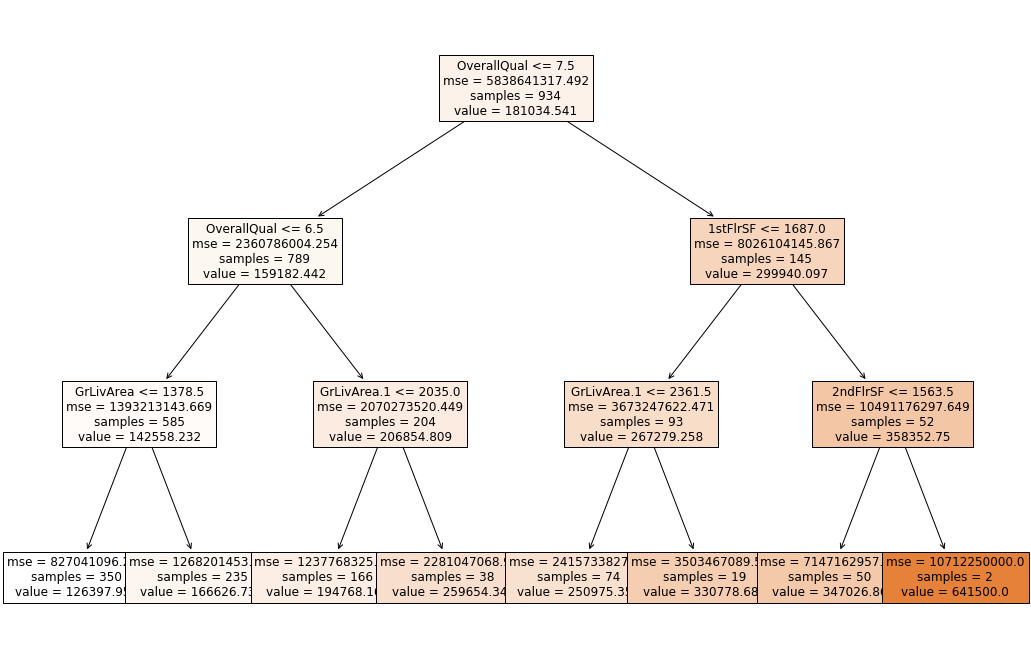

In [16]:
#Decision Tree for Ordinal Encoding
plt.figure(figsize = (18, 12))

plot_tree(OE_pipe[1], fontsize = 12, filled = True, feature_names = OE_pipe[0].transform(X_train).columns);

In [17]:
#Feature importance for Target Encoding
feats = pd.DataFrame({
    'Columns': TE_pipe[0].transform(X_train).columns,
    'Importance': TE_pipe[1].feature_importances_
})

feats.sort_values(by = 'Importance', ascending = False)

Columns  Importance
5    OverallQual    0.618505
4   Neighborhood    0.164257
9       1stFlrSF    0.101276
11   GrLivArea.1    0.073461
10      2ndFlrSF    0.042500
16  GarageFinish    0.000000
15   GarageYrBlt    0.000000
14    GarageType    0.000000
13      HalfBath    0.000000
12      FullBath    0.000000
0             Id    0.000000
1     MSSubClass    0.000000
8      GrLivArea    0.000000
7      YearBuilt    0.000000
6    OverallCond    0.000000
3        LotArea    0.000000
2       MSZoning    0.000000
17    GarageCars    0.000000

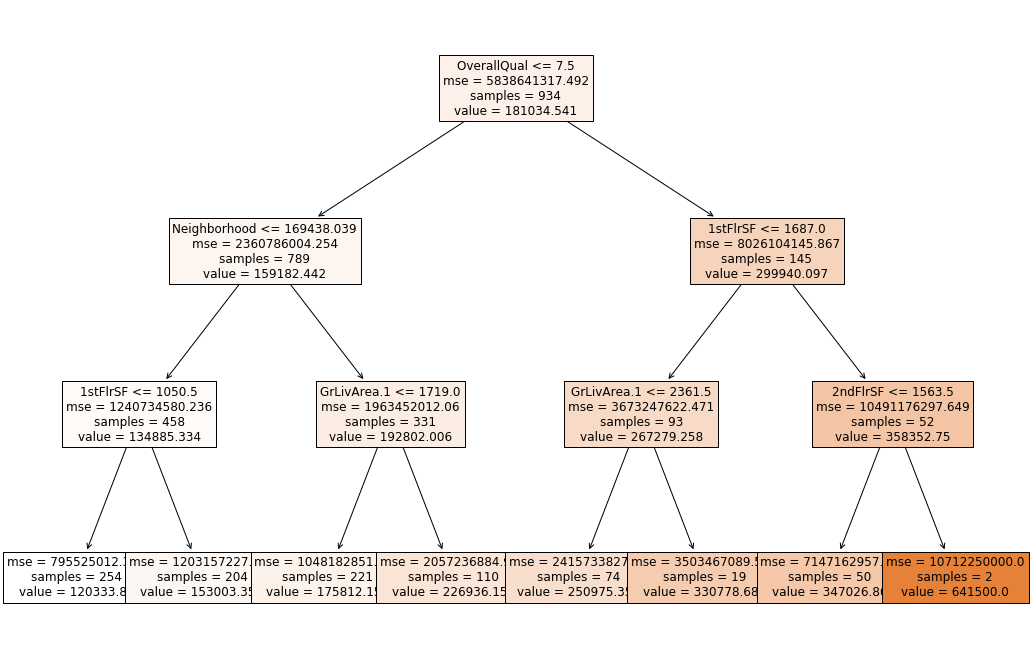

In [18]:
#Decision Tree for Target Encoding
plt.figure(figsize = (18, 12))

plot_tree(TE_pipe[1], fontsize = 12, filled = True, feature_names = TE_pipe[0].transform(X_train).columns);

Both trees produced the same initial split with Overall Quality but differ at the second level. Since Target Encoding produced the best results, we will use this method going forward.

## Feature Engineering

From looking at the data, there was a pretty large spread of Sales Prices that were recorded. Taking the log of the Sales Price column might help reduce the impact of outliers. I'll make a histogram first to see if it makes sense to try taking a log.

In [19]:
px.histogram(y_train)

In [20]:
px.histogram(np.log(y_train))

In [21]:
get_val_score(X_train,np.log(y_train),TE_pipe)

0.6941594097495614

Although the data does look like it would be a good candidate for applying log to, it does seem that our R square did take a dip by doing so. I will look a little deeper to see how taking the log of Sales Price may have changed feature importance of our model.

In [22]:
feats = pd.DataFrame({
    'Columns': TE_pipe[0].transform(X_train).columns,
    'Importance': TE_pipe[1].feature_importances_
})

feats.sort_values(by = 'Importance', ascending = False)

Columns  Importance
5    OverallQual    0.728735
8      GrLivArea    0.138053
7      YearBuilt    0.066550
4   Neighborhood    0.035850
17    GarageCars    0.030813
11   GrLivArea.1    0.000000
16  GarageFinish    0.000000
15   GarageYrBlt    0.000000
14    GarageType    0.000000
13      HalfBath    0.000000
12      FullBath    0.000000
0             Id    0.000000
10      2ndFlrSF    0.000000
1     MSSubClass    0.000000
6    OverallCond    0.000000
3        LotArea    0.000000
2       MSZoning    0.000000
9       1stFlrSF    0.000000

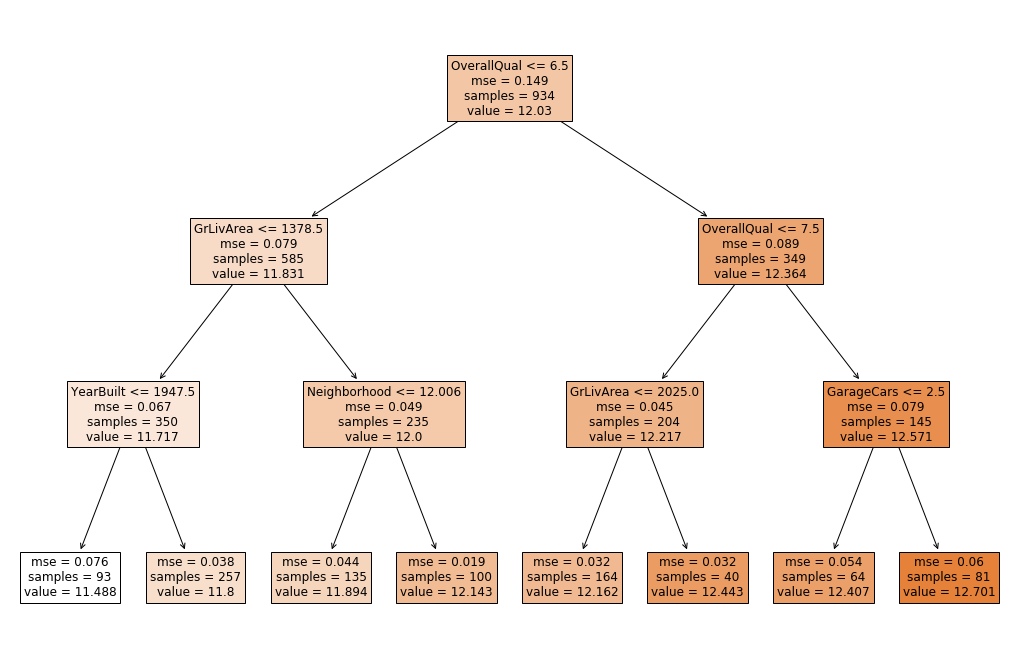

In [23]:
plt.figure(figsize = (18, 12))

plot_tree(TE_pipe[1], fontsize = 12, filled = True, feature_names = TE_pipe[0].transform(X_train).columns);

Looking at the feature importances and decision tree, it appears that taking the log of Sales Price brought greater weight to the Year Built column. However, this configuration yielded a lower model score so we will not proceed with using the log of Sales Price.

From here I will explore if creating some indicator columns around whether or not a house includes a 2nd floor or garage would improve our model.

In [24]:
X['2ndFlrInd'] = np.where(X['2ndFlrSF'] == 0, 0,1)
X['GarageInd'] = np.where(X['GarageType'] == 'NoGarage', 0,1)

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

In [26]:
get_val_score(X_train,y_train,TE_pipe)

0.7796919161465873

It looks like adding these columns in did not change the model score. Since we are a bit limited since there isn't a date column we can construct more features from, we will move on from here with our original model using Target Encoding.

## Hyper-Parameter Tuning

In this section I will test different parameter values to see what changes will produce the best results for our model.

In [25]:
max_depth = [3, 4, 5, 6, 7]
max_features = [0.4, 0.6, 0.8, 1]
min_samples_leaf = [5, 10, 20, 40]
cv_scores = []

for depth in max_depth:
    for feature in max_features:
        for sample in min_samples_leaf:
            print(f"Getting validation score for: depth: {depth}, max_features: {feature}, leaf_samples: {sample}")
            TE_pipe[-1].set_params(max_depth = depth, max_features = feature, min_samples_leaf = sample)
            # notice we are fitting on the log of the data
            val_score = get_val_score(X_train, y_train, TE_pipe)
            cv_scores.append((val_score, depth, feature, sample))

Getting validation score for: depth: 3, max_features: 0.4, leaf_samples: 5
Getting validation score for: depth: 3, max_features: 0.4, leaf_samples: 10
Getting validation score for: depth: 3, max_features: 0.4, leaf_samples: 20
Getting validation score for: depth: 3, max_features: 0.4, leaf_samples: 40
Getting validation score for: depth: 3, max_features: 0.6, leaf_samples: 5
Getting validation score for: depth: 3, max_features: 0.6, leaf_samples: 10
Getting validation score for: depth: 3, max_features: 0.6, leaf_samples: 20
Getting validation score for: depth: 3, max_features: 0.6, leaf_samples: 40
Getting validation score for: depth: 3, max_features: 0.8, leaf_samples: 5
Getting validation score for: depth: 3, max_features: 0.8, leaf_samples: 10
Getting validation score for: depth: 3, max_features: 0.8, leaf_samples: 20
Getting validation score for: depth: 3, max_features: 0.8, leaf_samples: 40
Getting validation score for: depth: 3, max_features: 1, leaf_samples: 5
Getting validation

In [27]:
cv_scores

[(0.6822244067512131, 3, 0.4, 5),
 (0.6168505032938731, 3, 0.4, 10),
 (0.7054502375453886, 3, 0.4, 20),
 (0.7151723279926543, 3, 0.4, 40),
 (0.7167776234572842, 3, 0.6, 5),
 (0.7372351967210735, 3, 0.6, 10),
 (0.7152314499138556, 3, 0.6, 20),
 (0.6124163513335709, 3, 0.6, 40),
 (0.7485101596592068, 3, 0.8, 5),
 (0.6544441674217198, 3, 0.8, 10),
 (0.720739284488243, 3, 0.8, 20),
 (0.7270551178797774, 3, 0.8, 40),
 (0.43916815148473987, 3, 1, 5),
 (0.49619948584274665, 3, 1, 10),
 (0.5968833938241419, 3, 1, 20),
 (0.5850845478159806, 3, 1, 40),
 (0.7550752735246911, 4, 0.4, 5),
 (0.7703263931467883, 4, 0.4, 10),
 (0.7131066754759956, 4, 0.4, 20),
 (0.6472590990092295, 4, 0.4, 40),
 (0.7833828680837174, 4, 0.6, 5),
 (0.7350688369344598, 4, 0.6, 10),
 (0.7635963453563268, 4, 0.6, 20),
 (0.709691977422644, 4, 0.6, 40),
 (0.7660003115465156, 4, 0.8, 5),
 (0.7010660272910451, 4, 0.8, 10),
 (0.7389392290362691, 4, 0.8, 20),
 (0.7167726123510703, 4, 0.8, 40),
 (0.5425315690553387, 4, 1, 5),
 (0

In [28]:
max(cv_scores)

(0.8305408219966348, 7, 0.4, 10)

It looks like a max depth of 7, max features of 40%, and min samples leaf of 10 produced the best results. We will update our model to use these paremeters.

In [27]:
TE_pipe[-1].set_params(max_depth = 7, max_features = 0.4, min_samples_leaf = 10)

DecisionTreeRegressor(max_depth=7, max_features=0.4, min_samples_leaf=10)

We will now run the model with the new parameter on all of our data and fit to our test data to get our final test score.

In [31]:
get_val_score(X,y,TE_pipe)

0.8240150696888822

To summarize, our model validation score was 0.83 and our test score was 0.82 which is as close as we would want a test score and model validation score to be. Most of the gain in our model was from the Hyper-Parameter Tuning we did.

In [32]:
feats = pd.DataFrame({
    'Columns': TE_pipe[0].transform(X_train).columns,
    'Importance': TE_pipe[1].feature_importances_
})

feats.sort_values(by = 'Importance', ascending = False)

Columns  Importance
5    OverallQual    0.557765
4   Neighborhood    0.178120
9       1stFlrSF    0.064112
3        LotArea    0.063907
8      GrLivArea    0.051655
11   GrLivArea.1    0.035508
10      2ndFlrSF    0.025988
15   GarageYrBlt    0.007670
7      YearBuilt    0.003911
16  GarageFinish    0.003645
6    OverallCond    0.002541
17    GarageCars    0.002216
1     MSSubClass    0.001340
13      HalfBath    0.001196
2       MSZoning    0.000427
18     2ndFlrInd    0.000000
0             Id    0.000000
14    GarageType    0.000000
12      FullBath    0.000000
19     GarageInd    0.000000

Looking at the final feature importance, we see there 5 columns that we can probably trim as they have an importance of 0.

In [24]:
X=X.drop(columns=['2ndFlrInd','Id','GarageType','FullBath','GarageInd'])

## Model Inference

Since OverallQual was our most important feature, we will explore how the the different values of OverallQual impacted SalePrice

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

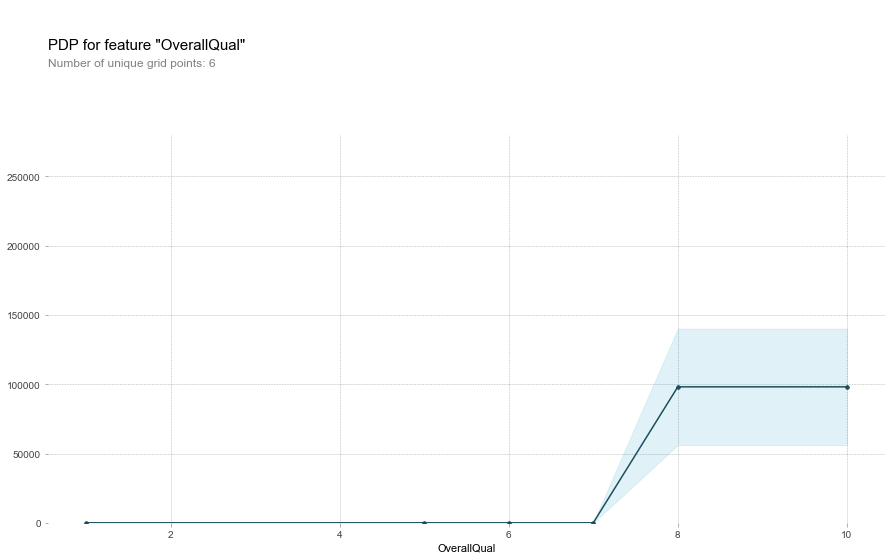

In [28]:
X_train_transformed = TE_pipe[0].transform(X_train)

X_train_cols = X_train_transformed.columns

pdp_OverallQualweight = pdp.pdp_isolate(
    model = TE_pipe[1], 
    
    dataset = TE_pipe[0].transform(X_train), 
    
    model_features = X_train_cols, 
    
    feature = 'OverallQual',
)

fig, axes = pdp.pdp_plot(pdp_OverallQualweight, 'OverallQual')

From our graph we see that once we hit value 7 and beyond, we start to see the impact of the OverallQual on Sales Price. However, it looks like we get diminishing returns after we hit a OverallQual score fo 8 and above. 

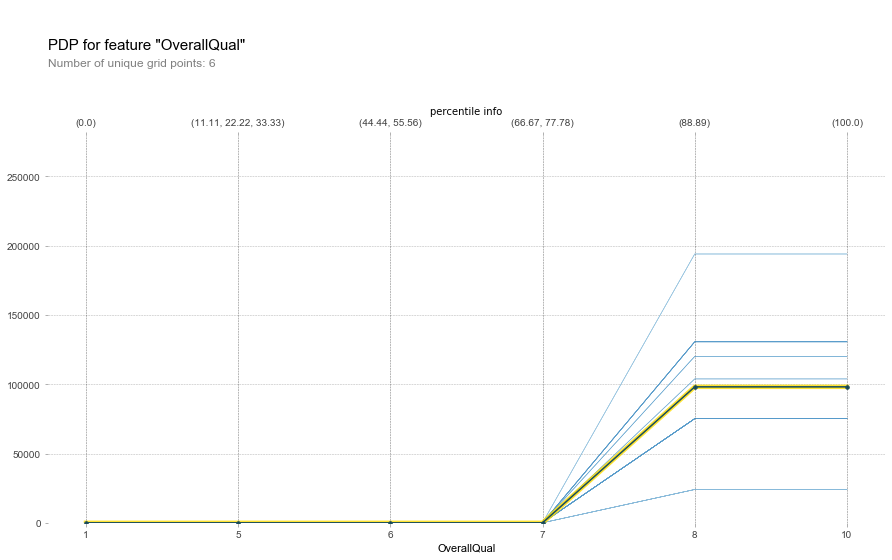

In [29]:
fig, axes = pdp.pdp_plot(
    pdp_OverallQualweight, 'OverallQual', plot_lines=True, frac_to_plot=100, x_quantile=True, 
 show_percentile=True
)

Looking at the chart above it looks like the distribution of PDP vals started to vary alot after OverallQual hits 7.